# 3. *K-medias con PySpark*


                                                              
En este notebook haremos una revisión de como usar la técnica de K-medias para tareas de agrupamiento (*clustering*). Esta libreta está basada del material del Mtro. Efraín Condés.

## 3.1 Introducción


Supongamos que tenemos una coleccion de puntos $\{\mathbf{x}_i \}_{i = 1}^n$ que viven en un espacio $N$-dimensional. Dichos puntos no están asociados a ningun tipo de clase o algo parecido. Sin embargo, nosotros podríamos estar interesados en encontrar elementos *similares* entre si. Los algoritmos de agrupamiento responden a esta necesidad, permitiéndonos crear grupos de objetos, de tal forma que los objetos dentro de un mismo grupo presentan cierto grado de *similaridad*.


K-medias (*K-means* en ingles) es una tecnica de agrupamiento, de las muchas que existen. Conceptualmente hablando, un paso difícil de difinir es como medir las similaridad entre objetos. En el caso particular de nuestro conjunto de puntos, la idea de que los puntos *similares* son los que están cerca entre si aparece de forma natural. K-medias hace uso justo esta idea, definiendo como medida de *similaridad* la distancia euclidiana


$$
d = ||\mathbf{x} - \mathbf{y}||_2 = \sqrt{\sum_i (x_i-y_i)^2} = \sqrt{(\mathbf{x} - \mathbf{y})^T (\mathbf{x} - \mathbf{y})}
$$


La idea general detrás K-medias es la de encontrar $K$ puntos $\{\mu_i\}_{i=1}^K$ que sirvan para representar grupos de elementos, de forma especifica son los promedios (por eso la palabra medias) de todos los puntos que encuentran en un mismo grupo. Cada punto puede ser asignado unicamente a un grupo, se le asigna al grupo representado por el $\mu_i$ más cercano.


De forma algorítmica, y muy a grosso modo, la técnica de K-medias puede describirse de la siguiente manera


1.   Inicializar K puntos $\mathbf{\mu}_1, \mathbf{\mu}_2, ...,\mathbf{\mu}_K$ de forma aleatoria.
2.   Encontrar el $\mathbf{\mu}_i$ que es mas cercano a cada $\mathbf{x}_i$, lo cual asignara automaticamente a cada $\mathbf{x}_i$ un grupo.
3.   Recalcule las medias $\mathbf{\mu}_1, \mathbf{\mu}_2, ...,\mathbf{\mu}_K$ usando los grupos encontrados en el paso 2.
4. Regrese al paso 2.


## 3.2 K-medias con `pyspark.ml`

Para empezar a hacer uso de PySpark es necesario crear una `SparkSession`, dicho objeto es el que nos permitirá crear RDDs o DataFrames, que son los objetos con los que más estaremos trabajando

In [0]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_medias').getOrCreate()

Ademas de `PySpark` usaremos las siguientes bibliotecas

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
# Para usar K-medias con pyspark
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.linalg import Vectors
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import * 

### 3.2.1 Datos


Para ilustrar el uso de K-medias creemos la siguiente base de datos

In [0]:
puntos, grupos_real = make_blobs(n_samples    = 100, 
                                 centers      = 2, 
                                 n_features   = 2, 
                                 random_state = 12) 

pdf_kmedias = pd.DataFrame(puntos, columns=['x','y']) #pandas
pdf_kmedias

,x,y
0,-10.064160,5.336130
1,-5.939345,0.293243
2,-4.282810,0.033378
3,-3.968270,0.646273
4,-5.580912,5.119659
...,...,...
95,-7.170647,4.874246
96,-1.692013,0.048707
97,-5.251409,0.278910
98,-6.360683,5.023713


Out[50]: <matplotlib.collections.PathCollection at 0x77b9f699cb50>

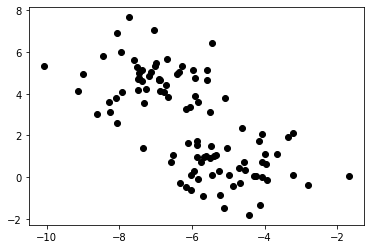

In [0]:
plt.scatter(pdf_kmedias['x'], pdf_kmedias['y'], c = 'black')

### 3.2.2 Preparar los datos

Para poder usar los modelos de `pyspark.ml` debemos reformatear los datos de la siguiente forma


In [0]:
# Da formato para poder usar datos en modelos de pyspark.ml

df_raw =  spark.createDataFrame(pdf_kmedias) #convertir pandas a DataFrame de Spark

df_kmedias = df_raw.withColumn('variables', array(df_raw.columns)) \
                      .rdd.map(lambda renglon: Vectors.dense(renglon.variables))

df_kmedias = spark.createDataFrame(df_kmedias.map(Row), ['variables'])

df_kmedias.show(5, truncate = False)

+----------------------------------------+
|variables                               |
+----------------------------------------+
|[-10.064159673950533,5.3361298235882115]|
|[-5.93934529638521,0.2932430254612975]  |
|[-4.282810462818456,0.03337804988534199]|
|[-3.9682695610300134,0.6462729900646167]|
|[-5.580911813734784,5.119659218324231]  |
+----------------------------------------+
only showing top 5 rows



### 3.2.3 Entrenar modelo

In [0]:
# k es el numero de grupos (clusters)
kmedias = KMeans(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)

### 3.2.4 Hacer predicciones

In [0]:
grupos_pred = modelo.transform(df_kmedias)

Pasemoslo a un DataFrame de pandas

In [0]:
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field variables. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Cambiamos a colores para graficar

In [0]:
grupos_colores = []

for g in grupos_pred:
  if g == 1:
    grupos_colores.append('blue')
  else:
    grupos_colores.append('red')

Out[56]: <matplotlib.collections.PathCollection at 0x77b9efcabfa0>

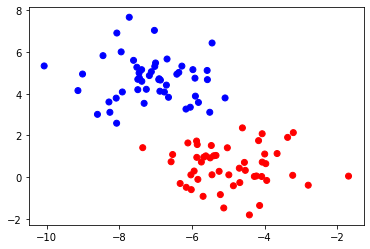

In [0]:
plt.scatter(pdf_kmedias['x'], pdf_kmedias['y'], c = grupos_colores)

### 3.2.5 Evaluar modelo


Podemos evaluar el modelo calculando la matriz de confusión

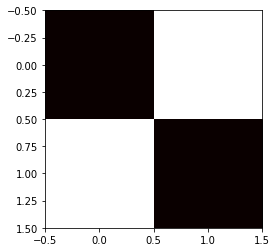

In [0]:
mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

## 3.3 Otras formas de agrupar
### 3.3.1 K-medias con distancia coseno

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field variables. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


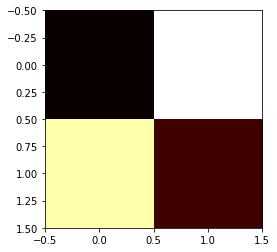

In [0]:
kmedias = KMeans(k = 2, seed = 1, featuresCol = 'variables', distanceMeasure = 'cosine')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()

### 3.3.2 *Gaussian mixture models*

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field variables. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


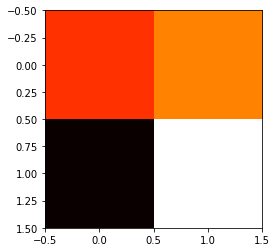

In [0]:
kmedias = GaussianMixture(k = 2, seed = 1, featuresCol = 'variables')
modelo = kmedias.fit(df_kmedias)
grupos_pred = modelo.transform(df_kmedias)
grupos_pred = grupos_pred.toPandas()
grupos_pred = grupos_pred['prediction']
grupos_pred[:5]

mat_cnf = confusion_matrix(grupos_real, grupos_pred)
plt.imshow(mat_cnf, cmap='hot', interpolation='nearest')
plt.show()